In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import sys
import numpy as np 
import pickle
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np


In [3]:
sys.path.append("/work/NLP/src")
from data.dataloaders.randomforest_loader import RFDataLoader
rf_loader = RFDataLoader(max_features=10000, ngram_range=(1,2))
from evaluate import ModelEvaluator

/work/NLP/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-13 13:26:23.957605: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 13:26:23.968206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739449583.980382   50975 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739449583.984143   50975 cuda_blas.cc:1418] Unable to regi

In [4]:
base_dir = Path("/work/NLP/data/processed")
dataset_types = ["unprocessed", "processed"]
splits = ["train", "test", "val"]
data = {}

for dataset_type in dataset_types:
    for split in splits:
        X_key = f"X_{split}_{dataset_type}"
        y_key = f"y_{split}_{dataset_type}"
        
        data[X_key] = pd.read_csv(base_dir / f"{X_key}.csv")
        data[y_key] = pd.read_csv(base_dir / f"{y_key}.csv")

        if isinstance(data[X_key], pd.DataFrame):
            data[X_key] = data[X_key].squeeze().tolist()

X_train_unprocessed, X_test_unprocessed, X_val_unprocessed = (
    data["X_train_unprocessed"], data["X_test_unprocessed"], data["X_val_unprocessed"]
)
y_train_unprocessed, y_test_unprocessed, y_val_unprocessed = (
    data["y_train_unprocessed"], data["y_test_unprocessed"], data["y_val_unprocessed"]
)
X_train_processed, X_test_processed, X_val_processed = (
    data["X_train_processed"], data["X_test_processed"], data["X_val_processed"]
)
y_train_processed, y_test_processed, y_val_processed = (
    data["y_train_processed"], data["y_test_processed"], data["y_val_processed"]
)

# Random Forest 

### Data Loader

In [5]:
X_train_processed = rf_loader.fit_transform(X_train_processed).toarray()
X_val_processed = rf_loader.transform(X_val_processed).toarray()
X_test_processed = rf_loader.transform(X_test_processed).toarray()

print("X_train_processed shape:", X_train_processed.shape)
print("X_val_processed shape:", X_val_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)


X_train_processed shape: (27810, 10000)
X_val_processed shape: (3968, 10000)
X_test_processed shape: (7948, 10000)


In [6]:
X_train_unprocessed = rf_loader.fit_transform(X_train_unprocessed).toarray()
X_val_unprocessed = rf_loader.transform(X_val_unprocessed).toarray()
X_test_unprocessed = rf_loader.transform(X_test_unprocessed).toarray()

print("X_train_unprocessed shape:", X_train_unprocessed.shape)
print("X_val_unprocessed shape:", X_val_unprocessed.shape)
print("X_test_unprocessed shape:", X_test_unprocessed.shape)

X_train_unprocessed shape: (27850, 10000)
X_val_unprocessed shape: (3975, 10000)
X_test_unprocessed shape: (7961, 10000)


In [7]:
y_train_processed = np.array(y_train_processed).squeeze()
y_val_processed = np.array(y_val_processed).squeeze()
y_test_processed = np.array(y_test_processed).squeeze()

y_train_unprocessed = np.array(y_train_unprocessed).squeeze()
y_val_unprocessed = np.array(y_val_unprocessed).squeeze()
y_test_unprocessed = np.array(y_test_unprocessed).squeeze()

## Model - Grid Search

In [8]:
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available processors
)


In [9]:
grid_search.fit(X_train_processed, y_train_processed)
print("Best parameters found:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total 

In [10]:
best_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=500,
    random_state=42
)

### Processed Lyrics 

In [11]:
best_rf.fit(X_train_processed, y_train_processed)
y_val_pred_processed = best_rf.predict(X_val_processed)
y_test_pred_processed = best_rf.predict(X_test_processed)

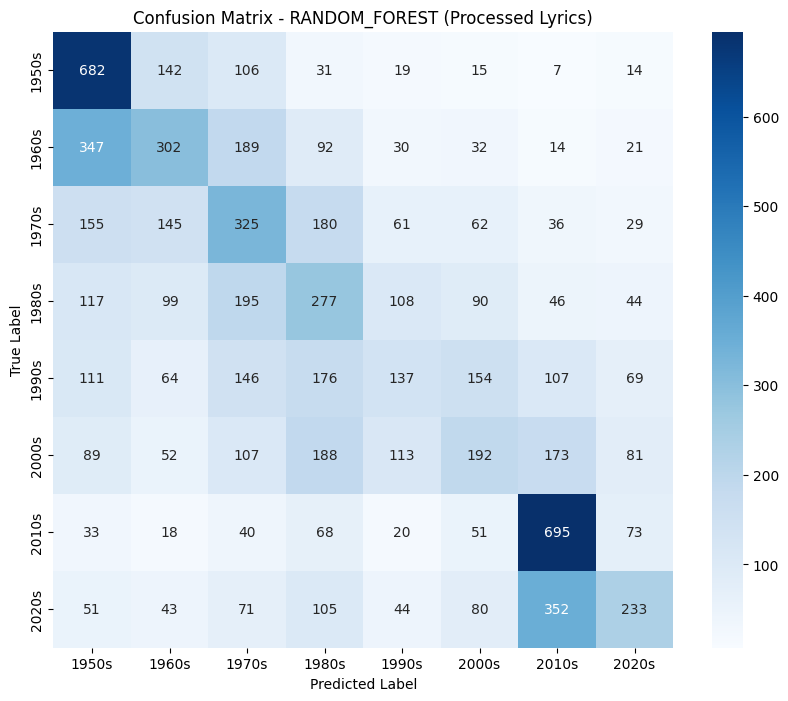

In [12]:
target_names = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

evaluator_processed = ModelEvaluator(y_test_processed, y_test_pred_processed, target_names, report_type="processed", model_name="random_forest")
evaluator_processed.evaluate()


### Random Forest - Unprocessed Lyrics 

In [13]:
best_rf.fit(X_train_unprocessed, y_train_unprocessed)


In [15]:
y_val_pred_unprocessed = best_rf.predict(X_val_unprocessed)
y_test_pred_unprocessed = best_rf.predict(X_test_unprocessed)

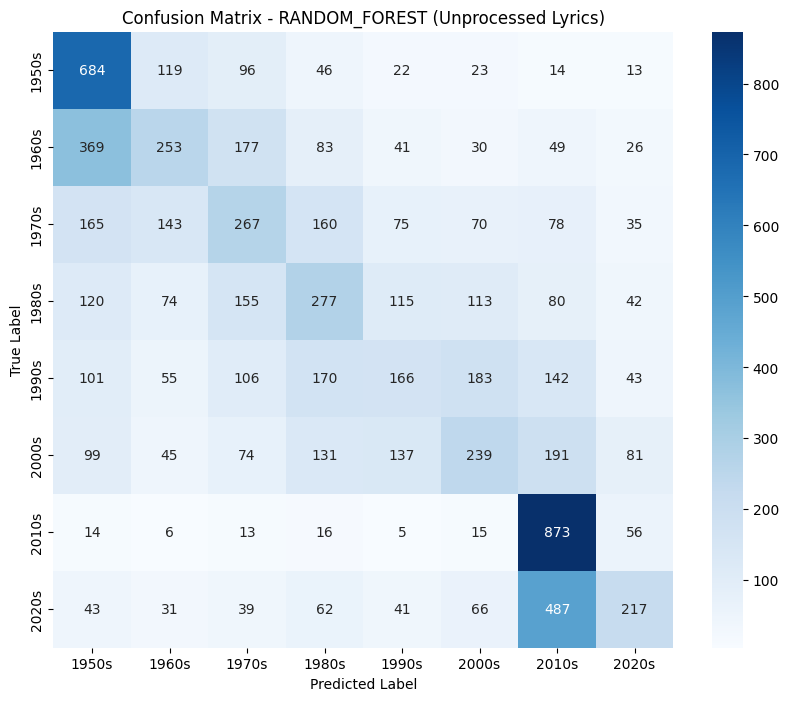

In [16]:
target_names = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']


evaluator_unprocessed = ModelEvaluator(y_test_unprocessed, y_test_pred_unprocessed, target_names, report_type="unprocessed", model_name="random_forest")
evaluator_unprocessed.evaluate()